In [ ]:

import kagglehub
praveengovi_emotions_dataset_for_nlp_path = kagglehub.dataset_download('praveengovi/emotions-dataset-for-nlp')

print('Data source import complete.')


100%|██████████| 721k/721k [00:00<00:00, 84.3MB/s]

Extracting files...
Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense, ReLU
from tensorflow.keras.layers import Embedding, BatchNormalization, Concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [ ]:
import os
train_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'train.txt')
val_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'val.txt')
test_path = os.path.join(praveengovi_emotions_dataset_for_nlp_path, 'test.txt')

In [ ]:
df = pd.read_csv(train_path,
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv(val_path,
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv(test_path,
                 delimiter=';', header=None, names=['sentence','label'])

In [ ]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
df.label.value_counts()

,count
label,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


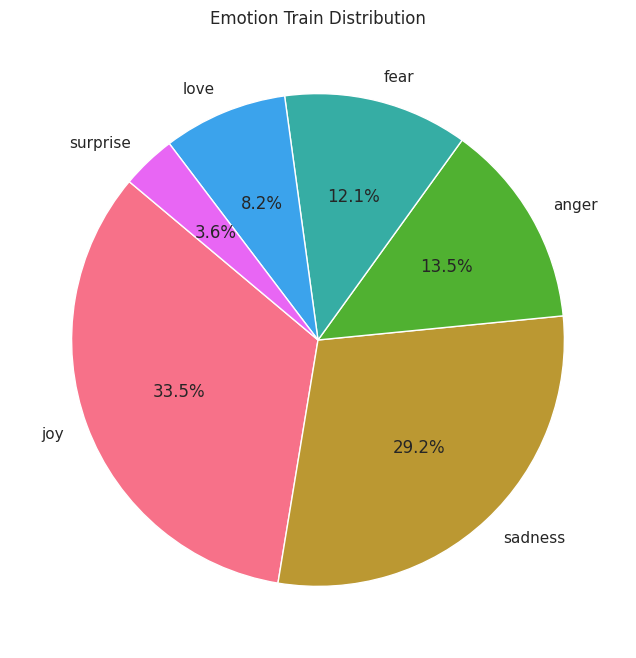

In [ ]:
# Count label distributions
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Train Distribution')
plt.show()

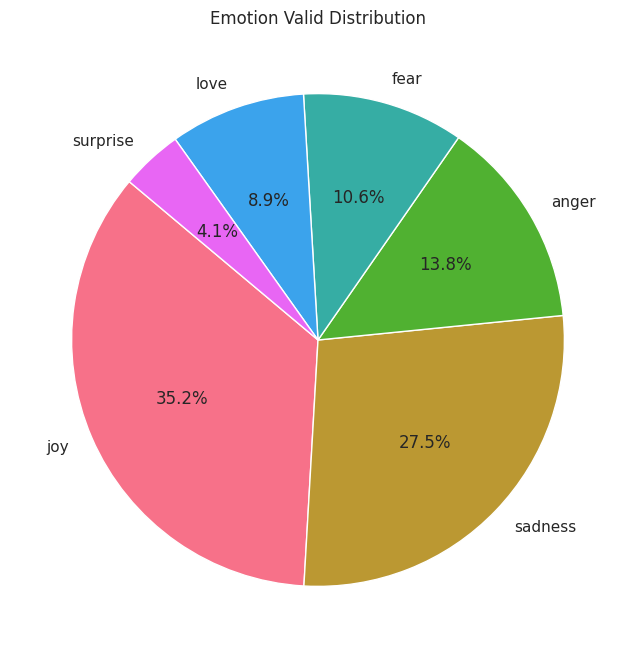

In [ ]:
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

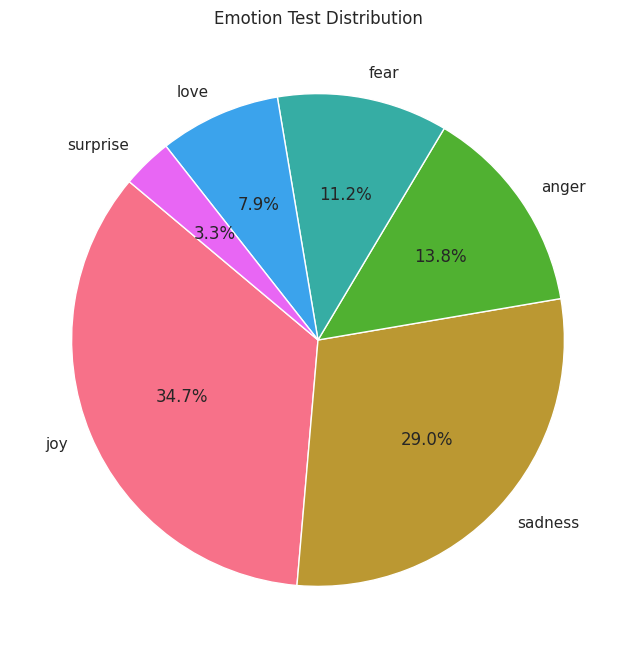

In [ ]:
# Count label distributions
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

### Since we have an unbalanced dataset, we can remove both surprise and love labels since they are the lowest and reduce each label to make the dataset balanced.

In [ ]:
df = df[~df['label'].str.contains('love')]
df = df[~df['label'].str.contains('surprise')]

In [ ]:
joy = df[df['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df[df['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = df[df['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df[df['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [ ]:
df.label.value_counts()

,count
label,
joy,2200
sadness,2200
anger,2159
fear,1937


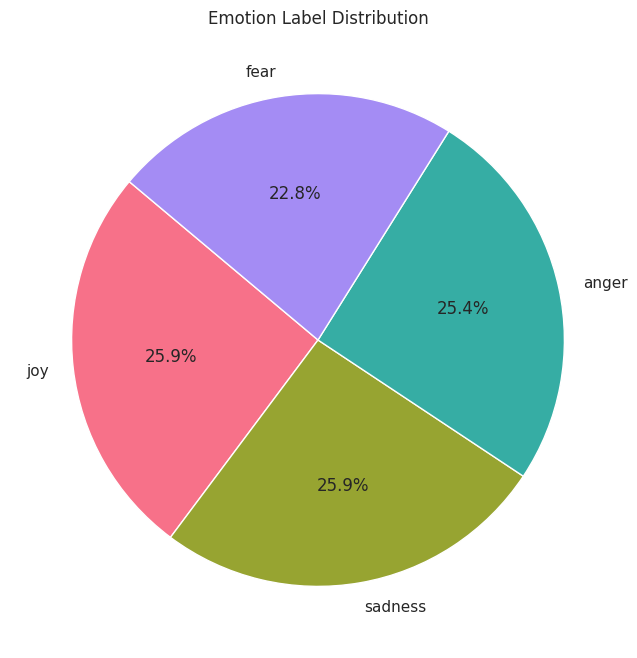

In [ ]:
# Count label distributions
label_counts = df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Label Distribution')
plt.show()

In [ ]:
val_df.label.value_counts()

,count
label,
joy,704
sadness,550
anger,275
fear,212
love,178
surprise,81


In [ ]:
val_df = val_df[~val_df['label'].str.contains('love')]
val_df = val_df[~val_df['label'].str.contains('surprise')]

In [ ]:
joy = val_df[val_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = val_df[val_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = val_df[val_df['label'] == 'fear'].sample(n=212, random_state=20)
anger = val_df[val_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

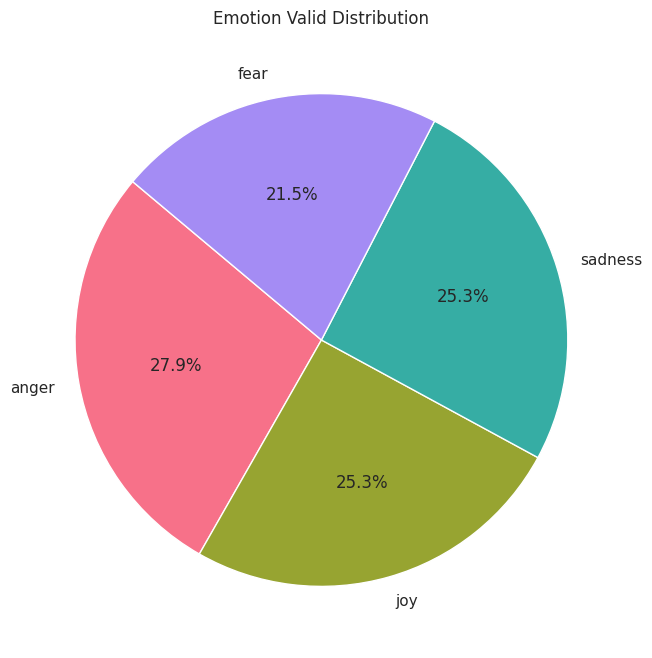

In [ ]:
# Count label distributions
label_counts = val_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Valid Distribution')
plt.show()

In [ ]:
ts_df.label.value_counts()

,count
label,
joy,695
sadness,581
anger,275
fear,224
love,159
surprise,66


In [ ]:
ts_df = ts_df[~ts_df['label'].str.contains('love')]
ts_df = ts_df[~ts_df['label'].str.contains('surprise')]

In [ ]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = ts_df[ts_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = ts_df[ts_df['label'] == 'fear'].sample(n=224, random_state=20)
anger = ts_df[ts_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

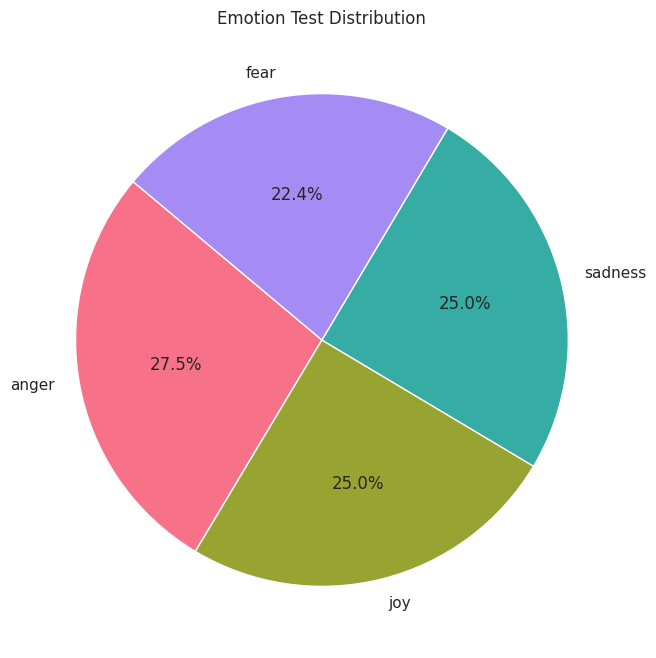

In [ ]:
# Count label distributions
label_counts = ts_df['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Emotion Test Distribution')
plt.show()

In [ ]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

In [ ]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=1000)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=1000)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=1000)
ts_y = to_categorical(ts_label)

In [ ]:
vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Dropout(.5))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='relu'))
cnn_model.add(Dropout(.5))
cnn_model.add(Dense(4, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# model = Sequential()
# model.add(Embedding(vocab_size, 32, input_length=50))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D(keepdims=True))
# model.add(Conv1D(64, 3, padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(ReLU())
# model.add(Dropout(.5))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(.5))
# model.add(Dense(6, activation='softmax'))

In [ ]:
cnn_model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# GlobalMaxPooling1D??

In [ ]:
batch_size = 64
epochs = 100
history = cnn_model.fit(tr_x, tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=(val_x, val_y))

Epoch 1/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.2540 - loss: 1.3918 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2553 - val_loss: 1.3855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 37s 205ms/step - accuracy: 0.2697 - loss: 1.3851 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2533 - val_loss: 1.3853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.2633 - loss: 1.3842 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2553 - val_loss: 1.3849 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.2598 - loss: 1.3851 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2634 - val_loss: 1.3844 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
133/133 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.2758 - los

In [ ]:
(loss, accuracy, percision, recall) = cnn_model.evaluate(tr_x, tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9047 - loss: 0.2421 - precision: 0.9783 - recall: 0.8511
Loss: 0.24, Accuracy: 0.9, Precision: 0.98, Recall: 0.85


In [ ]:
(loss, accuracy, percision, recall) = cnn_model.evaluate(ts_x, ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7401 - loss: 0.7346 - precision: 0.8317 - recall: 0.7017
Loss: 0.69, Accuracy: 0.74, Precision: 0.83, Recall: 0.7


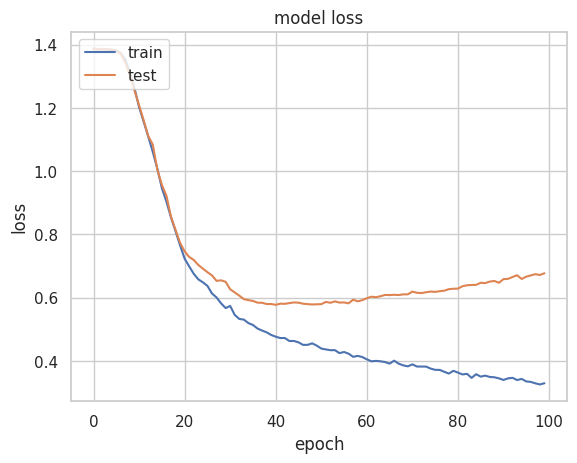

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

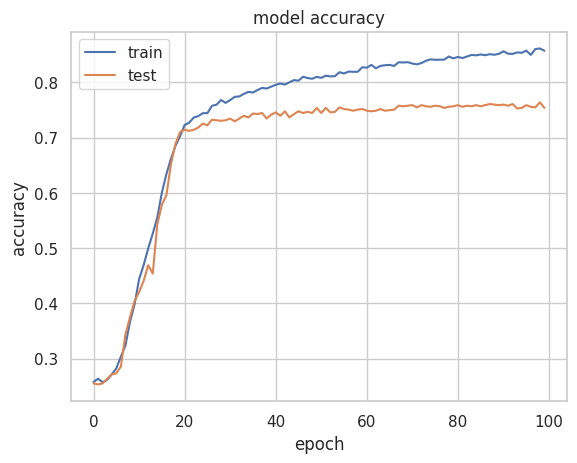

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
cnn_model.save("emotions_model.keras")